Got four filters of UVOT photometry contemporanious with HST spectra. Let's have a look

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from craftroom import resample
import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/photometry/mag_files/'

In [3]:
amags = glob.glob('{}*A_mag.fits'.format(path))
bcmags = glob.glob('{}*BC_mag.fits'.format(path))
print(amags, bcmags)

['/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/photometry/mag_files/uvm2_A_mag.fits', '/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/photometry/mag_files/uvw1_A_mag.fits', '/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/photometry/mag_files/uvw2_A_mag.fits', '/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/photometry/mag_files/u_A_mag.fits'] ['/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/photometry/mag_files/uvm2_BC_mag.fits', '/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/photometry/mag_files/uvw1_BC_mag.fits', '/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/photometry/mag_files/uvw2_BC_mag.fits', '/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/photometry/mag_files/u_BC_mag.fits']


In [4]:
cenwaves = dict(V=5468, B=4392, U=3465,UVW1=2600, UVM2=2246, UVW2=1928)
fwhms = dict(V=769, B=975, U=785, UVW1=693, UVM2=498, UVW2=657)

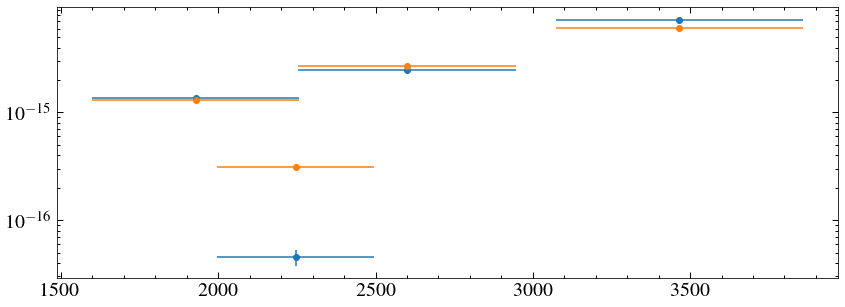

In [5]:
for phot in amags:
    data = fits.getdata(phot, 1)
    w, fwhm = cenwaves[data['FILTER'][0]], fwhms[data['FILTER'][0]]
    f, e = data['AB_FLUX_AA'], data['AB_FLUX_AA_ERR']
    plt.errorbar(w, f, yerr=e, xerr=fwhm/2, marker='o', ls='none', c='C0')
    
for phot in bcmags:
    data = fits.getdata(phot, 1)
    w, fwhm = cenwaves[data['FILTER'][0]], fwhms[data['FILTER'][0]]
    f, e = data['AB_FLUX_AA'], data['AB_FLUX_AA_ERR']
    plt.errorbar(w, f, yerr=e, xerr=fwhm/2, marker='o', ls='none', c='C1')
    
plt.yscale('log')

In [6]:
# hst data...
hstpath = '/media/david/2tb_ext_hd/hddata/meats/hst/ltt1445A/'
x1ds = np.hstack((glob.glob('{}*oeoo*x1d.fits'.format(hstpath)), glob.glob('{}*sx1.fits'.format(hstpath))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/ltt1445A/oeoo01010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/ltt1445A/oeoo01020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/ltt1445A/oeoo01030_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/ltt1445A/oeoo01040_sx1.fits'],
      dtype='<U68')

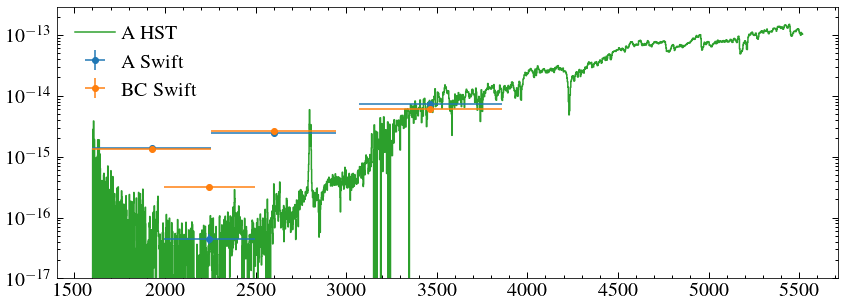

In [7]:
for x in x1ds[2:]:
    data = fits.getdata(x, 1)[0]
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G230L':
        mask = (w > 1600) & (w <3150)
        w_nuv, f_nuv, e_nuv = w[mask], f[mask], e[mask]
    if grating == 'G430L':
        mask = (w > 3150) & (w <5520)
        w_opt, f_opt, e_opt = w[mask], f[mask], e[mask]

plt.step(w_nuv, f_nuv, label='A HST', c='C2')
plt.step(w_opt, f_opt, zorder=-1, c='C2')

w_hst, f_hst, e_hst = np.hstack((w_nuv, w_opt)), np.hstack((f_nuv, f_opt)), np.hstack((e_nuv, e_opt))

plt.yscale('log')

for phot in amags:
    data = fits.getdata(phot, 1)
    w, fwhm = cenwaves[data['FILTER'][0]], fwhms[data['FILTER'][0]]
    f, e = data['AB_FLUX_AA'], data['AB_FLUX_AA_ERR']
    plt.errorbar(w, f, yerr=e, xerr=fwhm/2, marker='o', ls='none', c='C0', label = 'A Swift')
    
for phot in bcmags:
    data = fits.getdata(phot, 1)
    w, fwhm = cenwaves[data['FILTER'][0]], fwhms[data['FILTER'][0]]
    f, e = data['AB_FLUX_AA'], data['AB_FLUX_AA_ERR']
    plt.errorbar(w, f, yerr=e, xerr=fwhm/2, marker='o', ls='none', c='C1', label = 'BC Swift')
    
plt.yscale('log')
plt.ylim(1e-17)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [8]:
filters = glob.glob('/home/david/work/filters/uvot/*')
filters

['/home/david/work/filters/uvot/Swift_UVOT.V.dat',
 '/home/david/work/filters/uvot/Swift_UVOT.UVW1.dat',
 '/home/david/work/filters/uvot/Swift_UVOT.white.dat',
 '/home/david/work/filters/uvot/Swift_UVOT.UVW2.dat',
 '/home/david/work/filters/uvot/Swift_UVOT.UVM2.dat',
 '/home/david/work/filters/uvot/Swift_UVOT.U.dat',
 '/home/david/work/filters/uvot/Swift_UVOT.B.dat']

4577.495
1597.495
1597.495
1597.495
1597.495
2992.496
3437.496


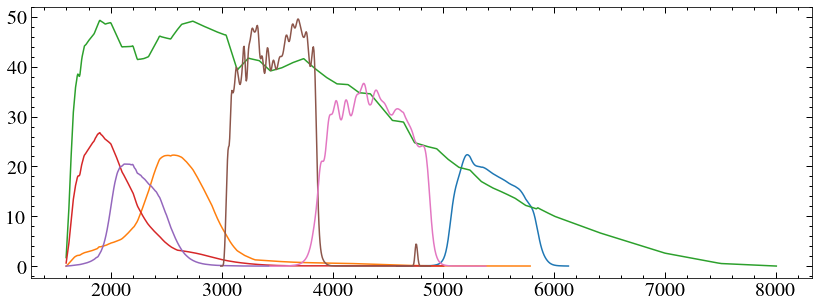

In [71]:
for filt in filters:
    bpw, bpf = np.loadtxt(filt, unpack=True)
    plt.plot(bpw, bpf)
    print(bpw[0])

In [10]:
def make_phot(bp_w, bp_cc, w, f, e=0):
    mask = (w >= bp_w[0]) & (w <= bp_w[-1])
    w, f = w[mask], f[mask]
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    flux = np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)
    if isinstance(e, int) != True:
        e = e[mask]
        intf = np.trapz(f, w)
        inte = (np.sum(e[1:]**2 * np.diff(w)**2))**0.5
        flux_error = (inte/intf)*flux
        return flux, flux_error
    else:
        return flux 

UVM2 [1.1164501]
UVW1 [2.0535572]
UVW2 [5.142882]
U [1.0526018]


(1.1e-17, 2.9042118028500896e-13)

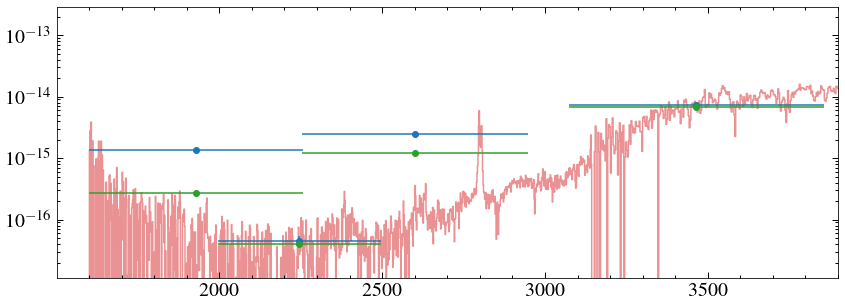

In [11]:
fpath = '/home/david/work/filters/uvot/'

for phot in amags:
    data = fits.getdata(phot, 1)
    w, fwhm = cenwaves[data['FILTER'][0]], fwhms[data['FILTER'][0]]
    f, e = data['AB_FLUX_AA'], data['AB_FLUX_AA_ERR']
    plt.errorbar(w, f, yerr=e, xerr=fwhm/2, marker='o', ls='none', c='C0')
    bpw, bpf = np.loadtxt('{}Swift_UVOT.{}.dat'.format(fpath, data['FILTER'][0] ), unpack=True)
    # plt.plot(bpw, bpf*1e-16)
    synphot, synphot_e = make_phot(bpw, bpf, w_hst, f_hst, e=e_hst)
    plt.errorbar(w, synphot, yerr=synphot_e, xerr=fwhm/2, marker='o', ls='none', c='C2')
    print(data['FILTER'][0], f/synphot)
    
plt.step(w_hst, f_hst, alpha=0.5, zorder=-1, c='C3')
plt.xlim(1501, 3900)
plt.yscale('log')
plt.ylim(1.1e-17)
    
    

Adding a phoenix model to better account for red leak

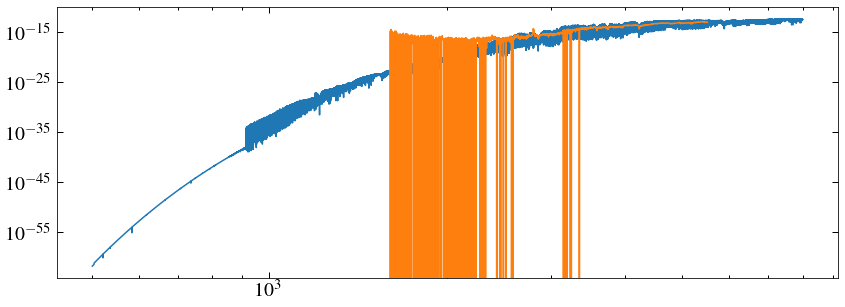

In [19]:
ptab = Table.read('phoenix_models/LTT1445A_phoenix_interpolated.ecsv')
pw, pf = ptab['WAVELENGTH'][ptab['WAVELENGTH'] < 8000], ptab['FLUX'][ptab['WAVELENGTH'] < 8000]*ptab.meta['NORMFAC']
plt.plot(pw, pf)
plt.yscale('log')
plt.xscale('log')

plt.plot(w_hst, f_hst)

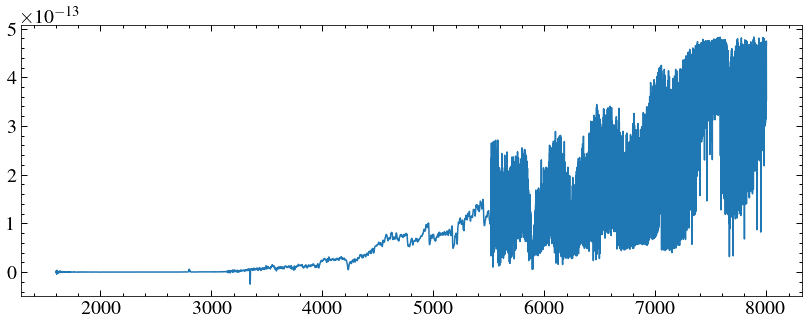

In [20]:
mask = pw > w_hst[-1]

w_spec, f_spec, e_spec = np.hstack((w_hst, pw[mask])), np.hstack((f_hst, pf[mask])), np.hstack((e_hst, 0.05*pf[mask]))
plt.plot(w_spec, f_spec)

UVM2 1.1164499927301814
UVW1 1.9792795830720789
UVW2 5.142881921262667
U 1.0526018040964997


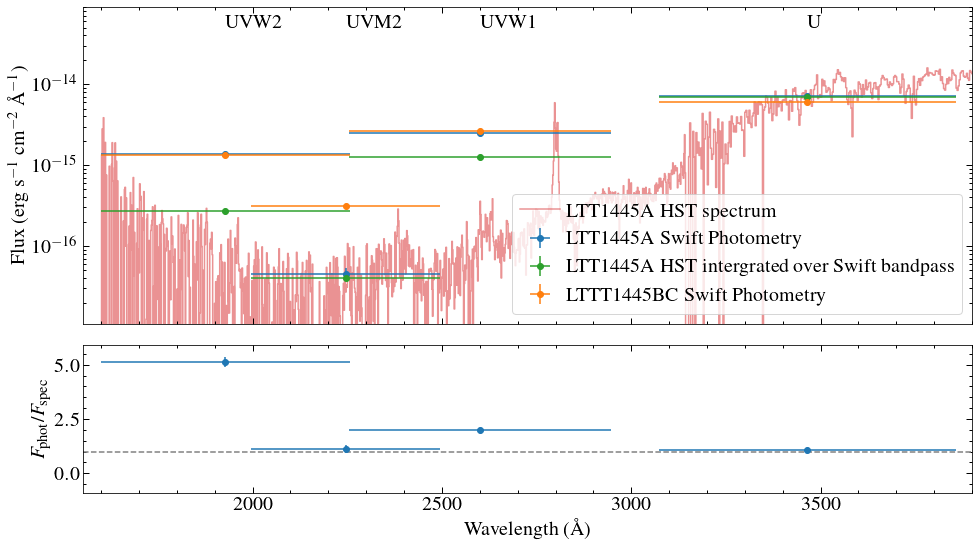

In [70]:
fig, ax = plt.subplots(figsize=(14, 8))
gs = GridSpec(6,1, figure=fig)


plt.subplot(gs[:4])
w_phot = []
fwhm_phot = []
f_phot = []
e_phot = []
f_syn = []
e_syn = []
fnames = []

for phot in amags:
    data = fits.getdata(phot, 1)
    w, fwhm = cenwaves[data['FILTER'][0]], fwhms[data['FILTER'][0]]
    fnames.append(data['FILTER'][0])
    f, e = data['AB_FLUX_AA'][0], data['AB_FLUX_AA_ERR'][0]
    w_phot.append(w)
    fwhm_phot.append(fwhm)
    f_phot.append(f)
    e_phot.append(e)
    # plt.errorbar(w, f, yerr=e, xerr=fwhm/2, marker='o', ls='none', c='C0')
    bpw, bpf = np.loadtxt('{}Swift_UVOT.{}.dat'.format(fpath, data['FILTER'][0] ), unpack=True)
    # plt.plot(bpw, bpf*1e-16)
    synphot, synphot_e = make_phot(bpw, bpf, w_spec, f_spec, e=e_spec)
    f_syn.append(synphot)
    e_syn.append(synphot_e)
    
    print(data['FILTER'][0], f/synphot)


w_phot, fwhm_phot, f_phot, e_phot, f_syn, e_syn = np.array(w_phot), np.array(fwhm_phot), np.array(f_phot), np.array(e_phot), np.array(f_syn), np.array(e_syn)

w_bc = []
f_bc = []
e_bc = []
fwhm_bc = []
for phot in bcmags:
    data = fits.getdata(phot, 1)
    w, fwhm = cenwaves[data['FILTER'][0]], fwhms[data['FILTER'][0]]
    f, e = data['AB_FLUX_AA'][0], data['AB_FLUX_AA_ERR'][0]
    w_bc.append(w)
    f_bc.append(f)
    e_bc.append(e)
    fwhm_bc.append(fwhm)
    
    # plt.errorbar(w, f, yerr=e, xerr=fwhm/2, marker='o', ls='none', c='C1)

w_bc, f_bc, e_bc, fwhm_bc = np.array(w_bc), np.array(f_bc), np.array(e_bc), np.array(fwhm_bc)
    
plt.errorbar(w_phot, f_phot, yerr=e_phot, xerr=fwhm_phot/2, marker='o', ls='none', c='C0', label='LTT1445A Swift Photometry')
plt.errorbar(w_phot, f_syn, yerr=e_syn, xerr=fwhm_phot/2, marker='o', ls='none', c='C2', label='LTT1445A HST intergrated over Swift bandpass')

plt.errorbar(w_bc, f_bc, yerr=e_bc, xerr=fwhm_bc/2, marker='o', ls='none', c='C1', label='LTTT1445BC Swift Photometry')
    
plt.step(w_hst, f_hst, alpha=0.5, zorder=-1, c='C3', label ='LTT1445A  HST spectrum')

plt.xlim(1551, 3900)
plt.yscale('log')
plt.ylim(1.1e-17, 9e-14)
plt.xticks(visible=False)
plt.legend(frameon =True, loc=4)
[plt.annotate(name, (wi, 5e-14)) for name, wi in zip(fnames, w_phot)]

plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.subplot(gs[4:])



f_rat = f_phot/f_syn
e_rat = f_rat*((e_syn/f_syn)**2+(e_phot/f_phot)**2)**0.5
plt.errorbar(w_phot, f_rat, yerr=e_rat, xerr=fwhm_phot/2, marker='o', ls='none', c='C0')
plt.axhline(1, ls='--', c='0.5')
plt.xlim(1551, 3900)
plt.ylim(-0.9, 5.9)

plt.ylabel('$F_{\mathrm{phot}}$/$F_{\mathrm{spec}}$')
plt.xlabel('Wavelength (\AA)')

plt.tight_layout()

plt.savefig('plots/ltt1445_swift_v_hst.png', facecolor='w')
plt.savefig('plots/ltt1445_swift_v_hst.pdf')